In [14]:
# # !pip install --upgrade pip
# !pip install qiskit_machine_learning
# !pip uninstall qiskit-terra -y
# !pip uninstall torchquantum -y

# !pip uninstall qiskit -y
# !pip uninstall qiskit-ibm-runtime -y

# !pip install qiskit==1.1.2
# !pip install qiskit-ibm-runtime

# !pip uninstall qiskit-aer -y
# !pip install qiskit-aer

Defaulting to user installation because normal site-packages is not writeable
  Using cached qiskit_ibm_runtime-0.37.0-py3-none-any.whl.metadata (20 kB)
  Using cached qiskit-2.0.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached qiskit_ibm_runtime-0.37.0-py3-none-any.whl (3.1 MB)
Using cached qiskit-2.0.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Attempting uninstall: qiskit
    Found existing installation: qiskit 1.1.2
    Uninstalling qiskit-1.1.2:
      Successfully uninstalled qiskit-1.1.2


In [1]:
import qiskit
import qiskit_machine_learning
import qiskit_ibm_runtime
import qiskit_aer

print('Qiskit Version :', qiskit.version.get_version_info())
print('Qiskit ML Version :', qiskit_machine_learning.__version__)
print('Qiskit-IBM-runtime Version :', qiskit_ibm_runtime.__version__)
print('Qiskit-Aer Version :', qiskit_aer.__version__)

Qiskit Version : 2.0.0
Qiskit ML Version : 0.8.2
Qiskit-IBM-runtime Version : 0.37.0
Qiskit-Aer Version : 0.17.0


# Qiskit QCNN Tutorial

In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345
estimator = Estimator()

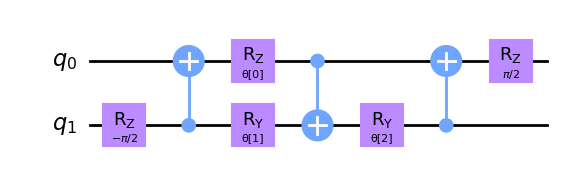

In [5]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

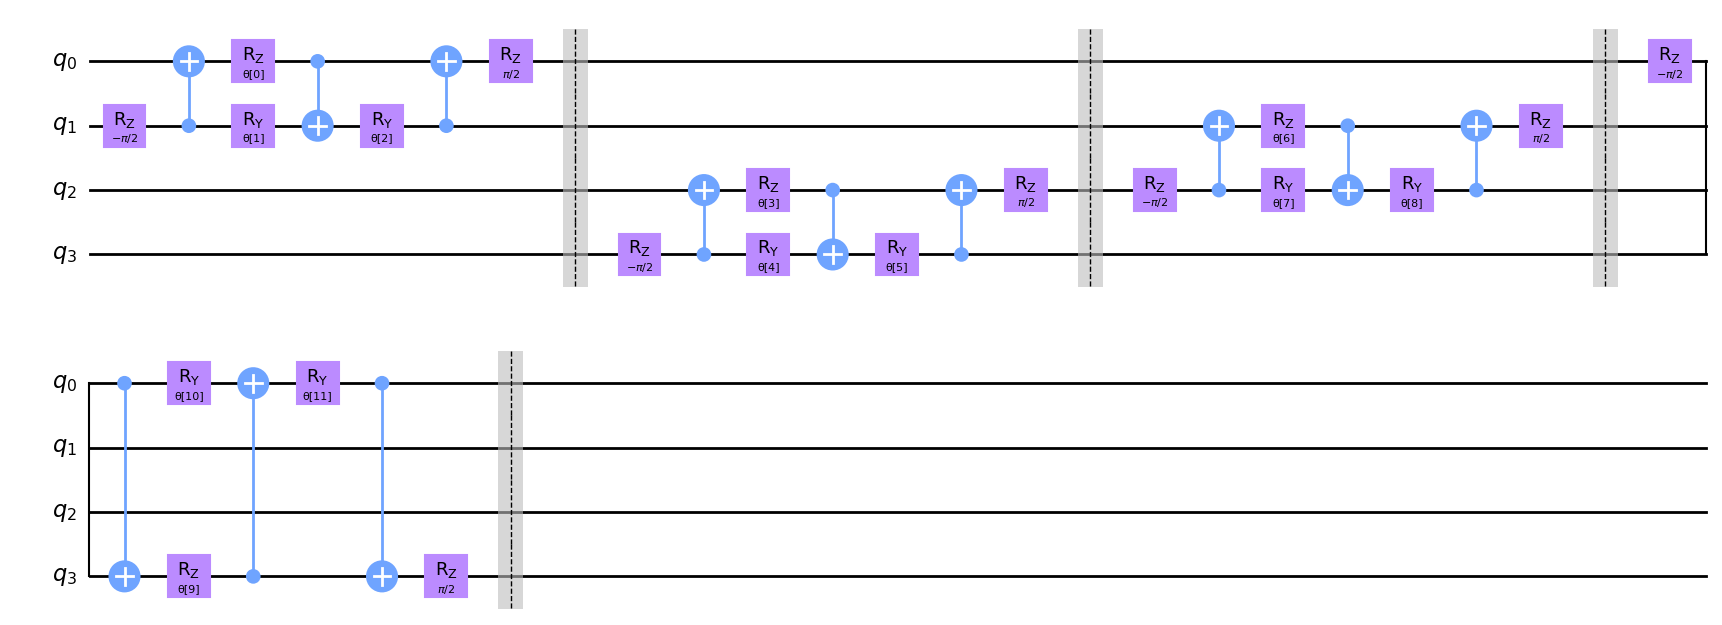

In [6]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

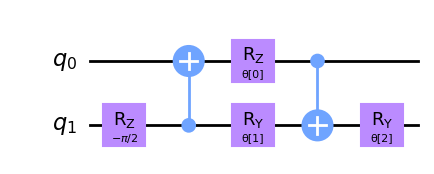

In [7]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

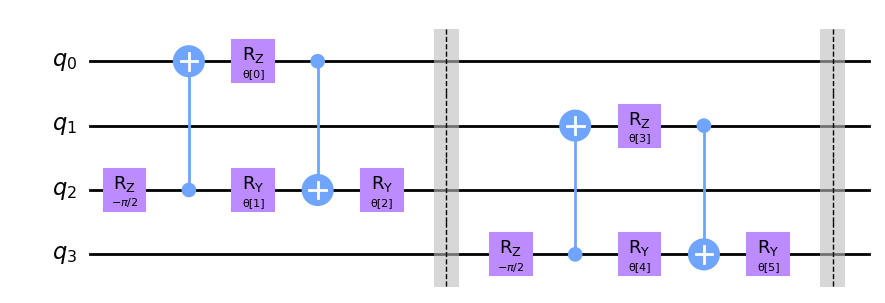

In [8]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

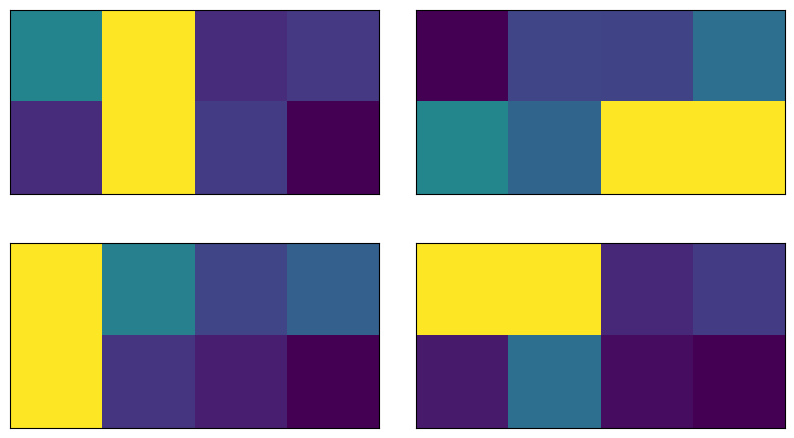

In [9]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

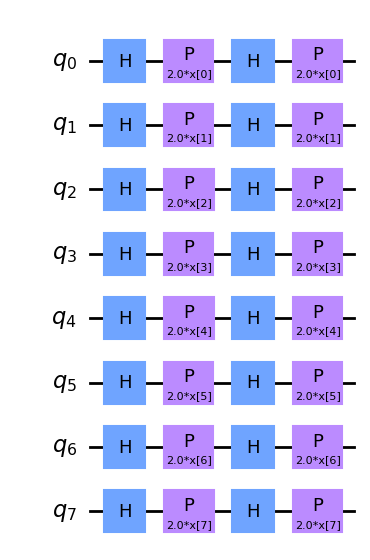

In [29]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

In [30]:
# feature_map = ZZFeatureMap(8)
# feature_map.decompose().draw("mpl", style="clifford")

In [11]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


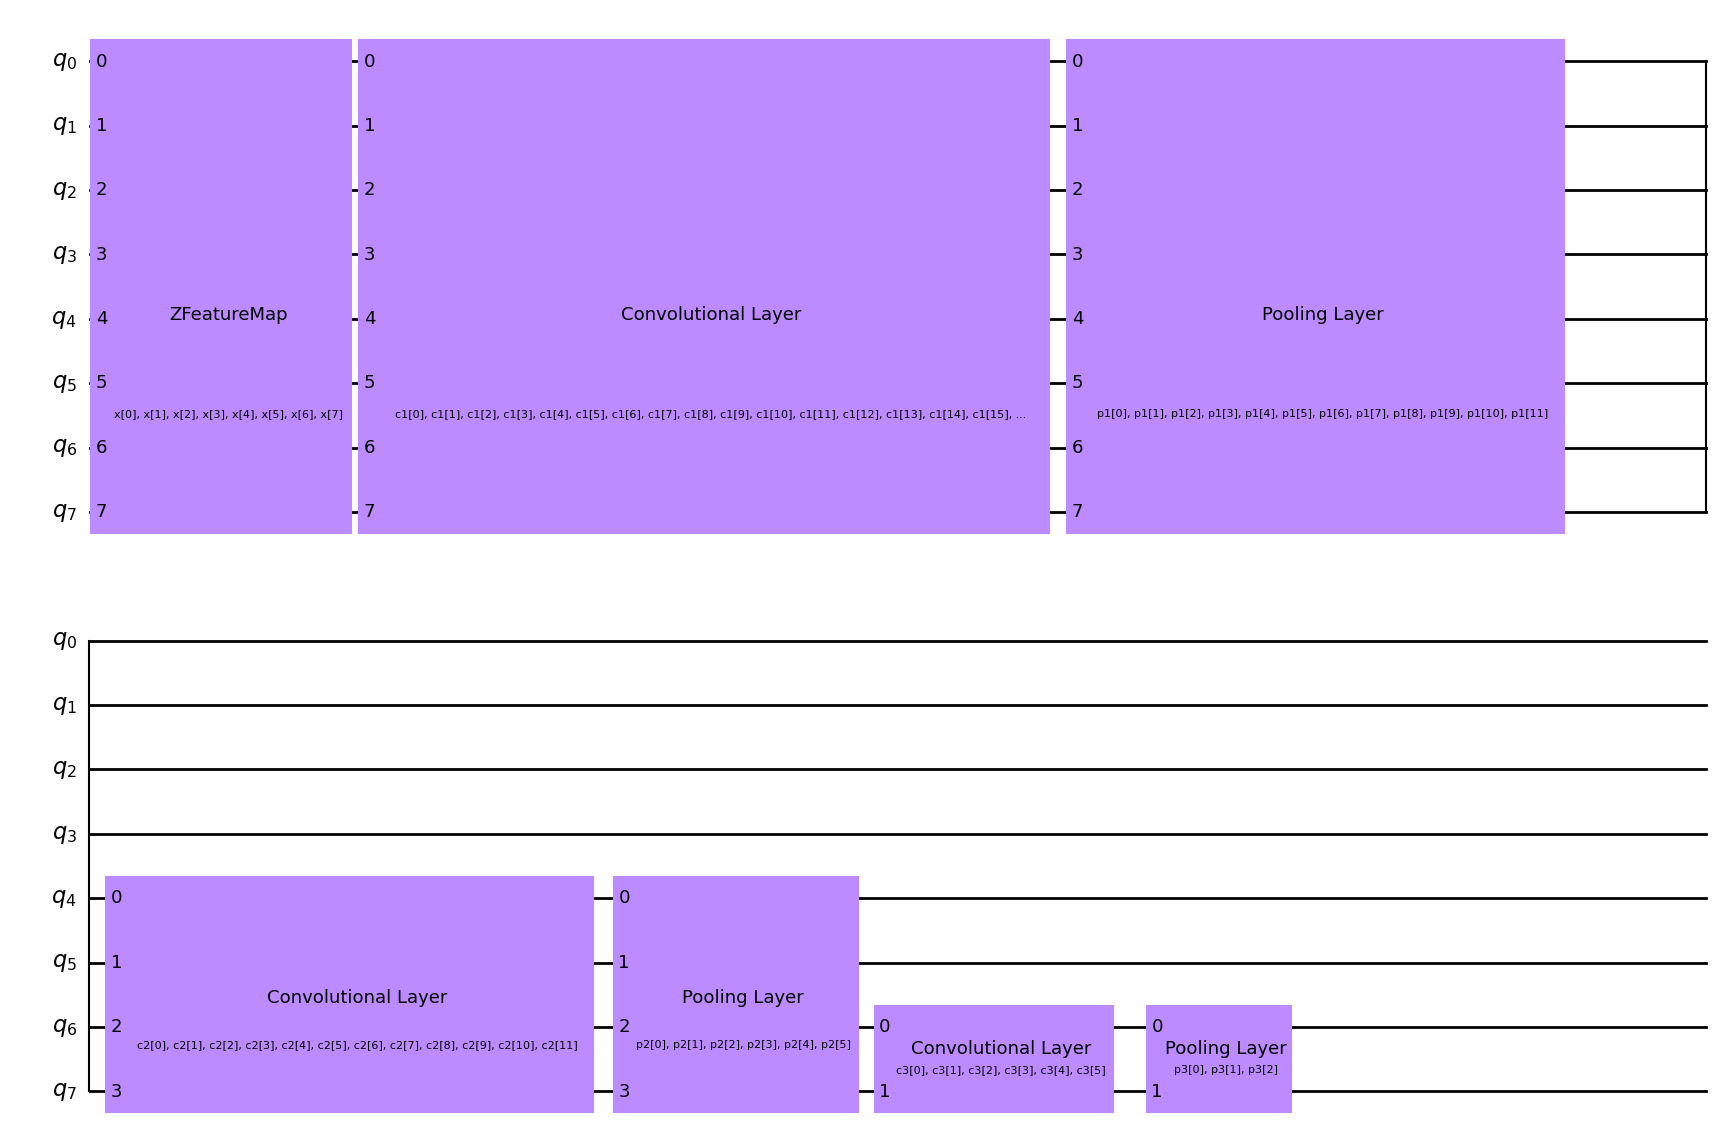

In [12]:
circuit.draw("mpl", style="clifford")

In [13]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [32]:
# with open("11_qcnn_initial_point.json", "r") as f:
#     initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point = None,
    # initial_point=initial_point,
)

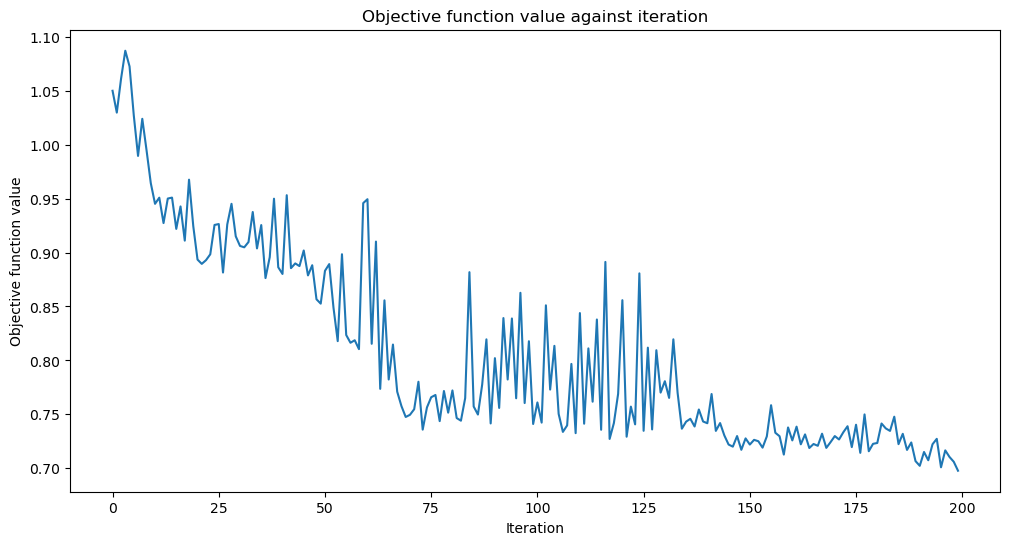

Accuracy from the train data : 85.71%


In [23]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 80.0%


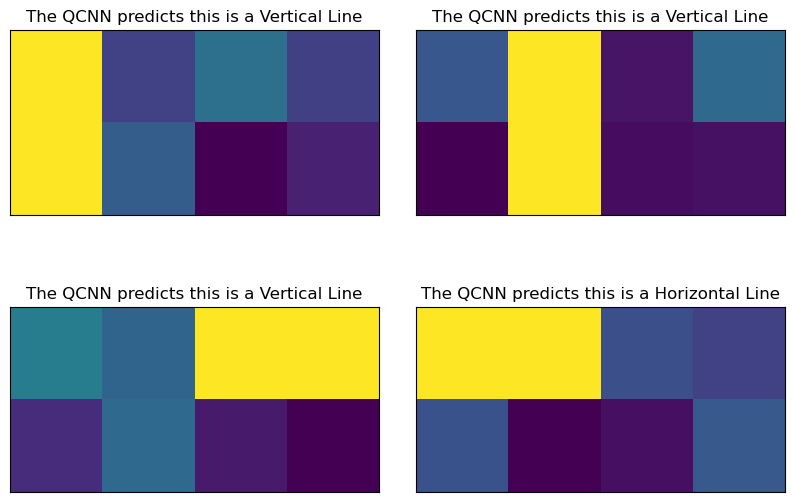

In [24]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

# Hybrid QCNN with MNIST

In [2]:
from qiskit import QuantumCircuit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.circuit.library import ZFeatureMap
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.utils import algorithm_globals

import random
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm
import copy
from sklearn.metrics import roc_auc_score
import copy
import time
from typing import Any, Optional, Tuple, Callable
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345
estimator = Estimator()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Running on ", device)

Running on  cuda


In [3]:
def conv_layer(num_qubits: int, name: str = "conv") -> QuantumCircuit:
    """
    Create a 'convolution' layer on `num_qubits`.
    Fill in whatever parametric gates / entangling pattern
    you like, sized to `num_qubits`.
    """
    qc = QuantumCircuit(num_qubits, name=name)
    # ------------------------------------------------
    # Example (placeholder): a layer of Rx, Rz gates
    # + ring entangling with CNOTs
    # ------------------------------------------------
    for q in range(num_qubits):
        theta = Parameter(f"θ_{name}_{q}")  # Qiskit parameter
        phi   = Parameter(f"φ_{name}_{q}")  # Qiskit parameter
        qc.ry(theta, q)
        qc.rz(phi,   q)
    # Entangle in a ring, e.g. CNOT(q, q+1 mod num_qubits)
    for q in range(num_qubits):
        qc.cx(q, (q+1) % num_qubits)

    return qc


def pool_layer(left_qubits: list[int], right_qubits: list[int], name: str = "pool") -> QuantumCircuit:
    """
    Pool pairs of qubits, one from `left_qubits` and one from `right_qubits`.
    Typically merges 2 qubits -> 1 logical qubit by a controlled operation.

    Note: The circuit you return must have a total 'width' equal to the
    sum of len(left_qubits) + len(right_qubits).
    """
    n_left = len(left_qubits)
    n_right = len(right_qubits)
    qc = QuantumCircuit(n_left + n_right, name=name)
    # Simple example: controlled-Z from each left qubit to each right qubit
    for i in range(min(n_left, n_right)):
        qc.cz(i, n_left + i)

    return qc

In [4]:
def build_qcnn(
    n_qubits: int,
    n_layers: int,
    estimator: Estimator,
    conv_layer_func=conv_layer,
    pool_layer_func=pool_layer,
):
    """
    Build a QCNN of `n_layers` (Conv+Pool blocks), each block halving the
    'active' qubits.  The final circuit = FeatureMap + all layers.
    Returns an EstimatorQNN.

    Parameters
    ----------
    n_qubits : int
        Total number of qubits (the circuit's width).
    n_layers : int
        Number of (Conv + Pool) blocks to stack.
    estimator : Estimator
        Qiskit's Estimator primitive for the QNN backend.
    conv_layer_func : callable
        Function that takes (num_qubits, name) -> parametric conv layer circuit
    pool_layer_func : callable
        Function that takes (left_indices, right_indices, name) -> parametric pool layer circuit

    Returns
    -------
    qnn : EstimatorQNN
        A Qiskit Machine Learning Estimator-based QNN.
    """

    # 1) Feature map
    feature_map = ZFeatureMap(n_qubits)
    # 2) Ansatz - the parametric part
    ansatz = QuantumCircuit(n_qubits, name="Ansatz")
    # We'll keep track of which subset of qubits are "active."
    # Start with them all: [0, 1, 2, ..., n_qubits-1]
    active_qubits = list(range(n_qubits))
    # Build each layer
    for layer_index in range(n_layers):
        layer_name = layer_index + 1
        # a) Convolution on the current active block
        conv_qc = conv_layer_func(len(active_qubits), f"c{layer_name}")
        ansatz.compose(conv_qc, qubits=active_qubits, inplace=True)
        # b) Pooling step:
        #    We'll split the active block into two halves: left vs right
        #    e.g., 8 -> (4 left, 4 right).
        half = len(active_qubits) // 2  # floor division
        left_block = active_qubits[:half]
        right_block = active_qubits[half:]
        pool_qc = pool_layer_func(left_block, right_block, f"p{layer_name}")
        ansatz.compose(pool_qc, qubits=active_qubits, inplace=True)
        # c) After pooling, the next layer should only act on the "right half" (for example).
        #    This mimics your example where you kept shifting from [0..7] -> [4..7] -> [6..7], etc.
        active_qubits = right_block
    # 3) Combine FeatureMap + Ansatz
    full_circuit = QuantumCircuit(n_qubits)
    full_circuit.compose(feature_map, range(n_qubits), inplace=True)
    full_circuit.compose(ansatz, range(n_qubits), inplace=True)
    # 4) Define an observable (example: measure Z on the first qubit, ignoring the rest)
    #    You can adapt as needed (e.g. a sum of Z's, or partial if you reduce qubits).
    obs_label = "Z" + "I" * (n_qubits - 1)
    observable = SparsePauliOp.from_list([(obs_label, 1.0)])
    # 5) Build the QNN
    qnn = EstimatorQNN(
        circuit=full_circuit.decompose(),
        observables=observable,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        estimator=estimator,
    )
    return qnn

In [5]:
class HybridQCNN(nn.Module):
    def __init__(self, n_qubits=8, n_layers=2, input_dim=784):
        super().__init__()
        # self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        # self.conv2 = nn.Conv2d(2, 16, kernel_size=5)
        # self.dropout = nn.Dropout2d()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, n_qubits)
        )
        qnn = build_qcnn(n_qubits=n_qubits, n_layers=n_layers, estimator=estimator)
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        # self.fc2 = nn.Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        reduced_x = self.fc(x)
        output = self.qnn(reduced_x)  # apply QNN
        
        return output.squeeze(1)

In [6]:
def load_mnist_binary(seed, n_train, n_valtest, device, batch_size, classes=(0, 1)):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Load dataset with transformation
    transform = Compose([ToTensor(), lambda x: x.view(-1)])  # Flatten MNIST images
    data_train = MNIST(root='./data', train=True, download=True, transform=transform)
    data_test = MNIST(root='./data', train=False, download=True, transform=transform)
    input_dim = 28 * 28

    # Filter for binary classes
    train_mask = (data_train.targets == classes[0]) | (data_train.targets == classes[1])
    test_mask = (data_test.targets == classes[0]) | (data_test.targets == classes[1])
    X_train = data_train.data[train_mask].float() / 255.0  # Normalize pixel values to [0, 1]
    y_train = data_train.targets[train_mask].clone().detach()
    X_test = data_test.data[test_mask].float() / 255.0
    y_test = data_test.targets[test_mask].clone().detach()

    # Binarize labels
    y_train = (y_train == classes[1]).long()
    y_test = (y_test == classes[1]).long()

    # Shuffle data
    shuffle_idx = torch.randperm(len(y_train))
    X_train = X_train[shuffle_idx]
    y_train = y_train[shuffle_idx]

    shuffle_idx2 = torch.randperm(len(y_test))
    X_test = X_test[shuffle_idx2]
    y_test = y_test[shuffle_idx2]

    # Flatten images
    X_train = X_train.view(-1, 28*28)
    X_test = X_test.view(-1, 28*28)

    # Create TensorDatasets
    train_X = X_train.to(device)
    train_y = y_train.to(device)
    test_X = X_test.to(device)
    test_y = y_test.to(device)

    train_dataset = TensorDataset(train_X, train_y)
    valtest_dataset = TensorDataset(test_X, test_y)

    # Equally split validation and test sets
    val_size = int(0.5 * len(valtest_dataset))
    test_size = len(valtest_dataset) - val_size
    val_dataset, test_dataset = random_split(valtest_dataset, [val_size, test_size])

    # DataLoader parameters
    params = {'shuffle': True, 'batch_size': batch_size} if batch_size > 0 else {'shuffle': True}
    test_params = {'shuffle': False, 'batch_size': batch_size} if batch_size > 0 else {'shuffle': False}

    train_loader = DataLoader(train_dataset, **params)
    val_loader = DataLoader(val_dataset, **test_params)
    test_loader = DataLoader(test_dataset, **test_params)
    
    return train_loader, val_loader, test_loader, input_dim

In [7]:
################################# Calculate Running Time ########################################
def epoch_time(start_time: float, end_time: float) -> Tuple[float, float]:
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


################################# Performance & Density Matrices ################################
# Training loop
def train_perf(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_outputs = []
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
        labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Collect labels and outputs for AUROC
        all_labels.append(labels.cpu().numpy())
        all_outputs.append(outputs.detach().cpu().numpy())       
        
    # Calculate train AUROC
    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    train_auroc = roc_auc_score(all_labels, all_outputs)
    
    return train_loss / len(dataloader), train_auroc


# Validation/Test loop
def evaluate_perf(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
            labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Collect labels and outputs for AUROC
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    auroc = roc_auc_score(all_labels, all_outputs)
    
    return running_loss / len(dataloader), auroc

In [8]:
def QuantumCNN_run(n_qubits, n_layers, input_dim, num_epochs):
    print("Running on ", device)
    model = HybridQCNN(n_qubits, n_layers, input_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    # criterion = nn.CrossEntropyLoss()   # Loss function for multi-class classification
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)
    # optimizer = COBYLA(maxiter=200)
        
    # Training process
    train_metrics, valid_metrics, test_metrics = [], [], []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})    
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    # Final evaluation on the test set
    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")
    test_metrics.append({'epoch': num_epochs, 'test_loss': test_loss, 'test_auc': test_auc}) 

    # Combine all metrics into a pandas DataFrame
    metrics = []
    for epoch in range(num_epochs):
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_metrics[epoch]['train_loss'],
            'train_auc': train_metrics[epoch]['train_auc'],
            'valid_loss': valid_metrics[epoch]['valid_loss'],
            'valid_auc': valid_metrics[epoch]['valid_auc'],
            'test_loss': test_metrics[0]['test_loss'],
            'test_auc': test_metrics[0]['test_auc'],
        })
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    # Save to CSV
    # csv_filename = f"QuantumCNN_performance.csv"
    # metrics_df.to_csv(csv_filename, index=False)
    # print(f"Metrics saved to {csv_filename}")
        
    return test_loss, test_auc

In [9]:
train_loader, val_loader, test_loader, input_dim = load_mnist_binary(seed=2025, n_train=70, n_valtest=30, device=device, batch_size=32)

In [11]:
QuantumCNN_run(n_qubits=6, n_layers=2, input_dim=input_dim, num_epochs=5)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Running on  cuda


100%|██████████| 34/34 [00:03<00:00, 10.16it/s]


Epoch: 01 | Time: 43m 58s
Train Loss: 0.6885, AUC: 0.6228 | Validation Loss: 0.6821, AUC: 0.7751


100%|██████████| 34/34 [00:02<00:00, 11.56it/s]


Epoch: 02 | Time: 44m 8s
Train Loss: 0.6832, AUC: 0.7696 | Validation Loss: 0.6786, AUC: 0.8481


100%|██████████| 34/34 [00:03<00:00, 10.66it/s]


Epoch: 03 | Time: 43m 28s
Train Loss: 0.6789, AUC: 0.8416 | Validation Loss: 0.6739, AUC: 0.8941


100%|██████████| 34/34 [00:02<00:00, 11.55it/s]


Epoch: 04 | Time: 43m 54s
Train Loss: 0.6739, AUC: 0.8606 | Validation Loss: 0.6683, AUC: 0.9127


100%|██████████| 34/34 [00:02<00:00, 11.37it/s]


Epoch: 05 | Time: 44m 29s
Train Loss: 0.6672, AUC: 0.8780 | Validation Loss: 0.6624, AUC: 0.9204


100%|██████████| 34/34 [00:02<00:00, 11.34it/s]

Test Loss: 0.6632, AUC: 0.8921


(0.663238946129294, 0.8920582317434016)